<a href="https://colab.research.google.com/github/lucia1299/BERTolde/blob/main/finetuning_umberto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets tokenizers seqeval -q

In [ ]:
import datasets
import numpy as np
from transformers import CamembertTokenizerFast, DataCollatorForTokenClassification, AutoModelForTokenClassification
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [ ]:
from datasets import Dataset, ClassLabel, Features, Sequence, Value, DatasetDict

def creationdictionary(data, posdict, nerdict, pos_tags_list, ner_tags_list):
    container_list = []

    while data:
        container_dict = {}
        pos_list = []
        ner_list = []
        words_list = []

        index_of_empty_list = data.index([]) if [] in data else len(data)
        tokenized_data1 = data[0: index_of_empty_list]
        for n in tokenized_data1:
            if 'id' not in container_dict:
                container_dict['id'] = 0
            else:
                container_dict['id'] += 1
            if n[1] in posdict:
                pos_list.append(posdict[n[1]])
            if n[3] in nerdict:
                ner_list.append(nerdict[n[3]])
            words_list.append(n[0])

        container_dict['pos'] = pos_list
        container_dict['ner_tags'] = ner_list
        container_dict['tokens'] = words_list
        container_dict['issueid'] = tokenized_data1[0][2]
        container_dict['id'] = str(container_dict['id'])

        container_list.append(container_dict)

        data = data[index_of_empty_list + 1:]

    container_dict = {key: [d[key] for d in container_list] for key in container_list[0]}

    ds = Dataset.from_dict(container_dict, features=Features({
        'pos': Sequence(ClassLabel(names=pos_tags_list)),
        'ner_tags': Sequence(ClassLabel(names=ner_tags_list)),
        'tokens': Sequence(Value(dtype='string')),
        'issueid': Value(dtype='string'),
        'id': Value(dtype='string')
        }))

    return ds

def posconversion(data):
    posdict = {}
    set1 = set()
    for i in data:
        if len(i) >= 1:
            pos_tag = i[1]
            set1.add(pos_tag)
    pos_tags_list = list(set1)
    v = 0
    for i in set1:
        posdict[i] = v
        v +=1
    return posdict, pos_tags_list

def nerconversion(data):
    nerdict = {}
    set1 = set()
    for i in data:
        if len(i) >= 4:
            ner_tag = i[3]
            set1.add(ner_tag)
    ner_tags_list = list(set1)
    v = 0
    for i in set1:
        nerdict[i] = v
        v +=1
    return nerdict, ner_tags_list

file_path_training = '/content/I-CAB-evalita09-NER-training.iob2'
file_path_test = '/content/I-CAB-evalita09-NER-test.iob2'

def read_iob_data(file_path):
     with open(file_path, 'r', encoding='ISO-8859-1') as file:
         iob_data = file.readlines()

     data = [line.strip().split() for line in iob_data]
     return data

data_training = read_iob_data(file_path_training)
posdict, pos_tags_list = posconversion(data_training)
nerdict, ner_tags_list = nerconversion(data_training)
result_training = creationdictionary(data_training, posdict, nerdict, pos_tags_list, ner_tags_list)

data_test = read_iob_data(file_path_test)
posdict, pos_tags_list = posconversion(data_test)
nerdict, ner_tags_list = nerconversion(data_test)
result_test = creationdictionary(data_test, posdict, nerdict, pos_tags_list, ner_tags_list)

main_dataset = DatasetDict({"train": result_training, "test": result_test})
print(main_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'pos', 'ner_tags', 'tokens', 'issueid'],
        num_rows: 11227
    })
    test: Dataset({
        features: ['id', 'pos', 'ner_tags', 'tokens', 'issueid'],
        num_rows: 4136
    })
})


In [ ]:
main_dataset.shape

{'train': (11227, 5), 'test': (4136, 5)}

In [ ]:
main_dataset['train'][1]

{'id': '6',
 'pos': [12, 10, 12, 40, 0, 49, 11],
 'ner_tags': [8, 8, 8, 8, 8, 8, 6],
 'tokens': ['Latte', 'al', 'seno', ',', 'sos', 'di', 'Pedrotti'],
 'issueid': 'adige20041007_id413942'}

In [ ]:
main_dataset['train'].features['ner_tags']

Sequence(feature=ClassLabel(names=['I-PER', 'B-GPE', 'B-LOC', 'I-ORG', 'I-LOC', 'B-ORG', 'B-PER', 'I-GPE', 'O'], id=None), length=-1, id=None)

In [ ]:
tokenizer = CamembertTokenizerFast.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1")

#add_prefix_space needs to be used because this is how the instatiation of RobertaTokenizerFast works

In [ ]:
example_text = main_dataset['train'][1]

tokenized_input = tokenizer(example_text['tokens'], is_split_into_words=True)

tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])

word_ids = tokenized_input.word_ids()

#ValueError: word_ids() is not available when using non-fast tokenizers (e.g. instance of a `XxxTokenizerFast` class).
#this is why we need to use TokenizersFast also for Roberta

word_ids


[None, 0, 1, 2, 3, 4, 5, 6, 6, None]

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
tokens

#<s> and </s> are mapped to NONE because the they are "special tokens"

['<s>', '▁Latte', '▁al', '▁seno', '▁,', '▁sos', '▁di', '▁Pedro', 'tti', '</s>']

In [ ]:
len(example_text['ner_tags']), len(tokenized_input['input_ids'])

(7, 10)

In [ ]:
def tokenize_and_align_labels(example, label_all_tokens =True):
    tokenized_input = tokenizer(example['tokens'], truncation=True, is_split_into_words=True)

    labels = []

    for i, label in enumerate(example['ner_tags']):
        word_ids = tokenized_input.word_ids(batch_index=i)
        #it returns a list indicating the word corresponding to each token
        previous_word_idx = None

        label_ids =[]

        for word_idx in word_ids:
            if word_idx is None:
                #special tokens
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                #regular case
                label_ids.append(label[word_idx])
            else:
                #subword case
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_input['labels'] = labels
    return tokenized_input

In [ ]:
q = tokenize_and_align_labels(main_dataset['train'][4:5])
print(q)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[5, 2856, 339, 29391, 56, 3101, 3294, 76, 31917, 8973, 98, 20480, 21, 31220, 36, 11780, 801, 21, 9985, 49, 1665, 6801, 801, 21, 20270, 13, 337, 126, 448, 83, 11613, 59, 1809, 216, 2000, 8173, 1048, 6]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100]]}


In [ ]:
for token, label in zip(tokenizer.convert_ids_to_tokens(q['input_ids'][0]), (q['labels'][0])):
    print(f"{token:_<40} {label}")

<s>_____________________________________ -100
▁Oggi___________________________________ 8
▁alle___________________________________ 8
▁17.30__________________________________ 8
▁al_____________________________________ 8
▁Centro_________________________________ 8
▁culturale______________________________ 8
▁S______________________________________ 8
._______________________________________ 8
▁Chiara_________________________________ 8
▁si_____________________________________ 8
▁parlerà________________________________ 8
▁di_____________________________________ 8
▁allattamento___________________________ 8
▁in_____________________________________ 8
▁Trentino_______________________________ 1
▁,______________________________________ 8
▁di_____________________________________ 8
▁mamme__________________________________ 8
▁con____________________________________ 8
▁tanti__________________________________ 8
▁dubbi__________________________________ 8
▁,______________________________________ 8
▁di_____

In [ ]:
tokenized_dataset = main_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/11227 [00:00<?, ? examples/s]

Map:   0%|          | 0/4136 [00:00<?, ? examples/s]

In [ ]:
num_labels = main_dataset['train'].features['ner_tags'].feature.num_classes
num_labels

9

In [ ]:

model = AutoModelForTokenClassification.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1", num_labels = num_labels)

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install accelerate -U

In [ ]:
pip install transformers[torch]

In [ ]:
from transformers import TrainingArguments, AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=2e-5)

scheduler = get_linear_schedule_with_warmup(optimizer, 1400, 17400)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#define training arguments parameters
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    "test-ner",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=6,
    weight_decay=0.01,
)

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)
#objects that will form a batch by using a list of dataset elements as input - they are the same type of the elements of the trian dataset

In [ ]:
metric = datasets.load_metric('seqeval')
#utureWarning: load_metric is deprecated and will be removed in the next major version of datasets.
# Use 'evaluate.load' instead, from the new library 🤗
example = main_dataset['train'][0]

<ipython-input-22-1a25687c91d7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric('seqeval')


In [ ]:
label_list = main_dataset['train'].features['ner_tags'].feature.names
label_list

['I-PER', 'B-GPE', 'B-LOC', 'I-ORG', 'I-LOC', 'B-ORG', 'B-PER', 'I-GPE', 'O']

In [ ]:
example = main_dataset['train'][1]

In [ ]:
#calculate the metric on a single example (the first of the train dataset)
labels = [label_list[i] for i in example['ner_tags']]
labels

['O', 'O', 'O', 'O', 'O', 'O', 'B-PER']

In [ ]:
#check metric.compute works
metric.compute(predictions=[labels], references=[labels])
#the score of this is very high because I pass the same list to both my predictions and references

{'PER': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [ ]:
def compute_metrics(eval_preds):
    pred_logits, labels = eval_preds

    # pred_logits are obtained by passing numpy.argmax
    pred_logits = np.argmax(pred_logits, axis=2)
    # the logits and the probabilities are in the same order,
    # so we don’t need to apply the softmax

    # We remove all the values where the label is -100
    # define the variable prediction here
    predictions = [
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(pred_logits, labels)
    ]
    # define the variable true_labels here
    true_labels = [
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100]
       for prediction, label in zip(pred_logits, labels)
    ]
    results = metric.compute(predictions=predictions, references=true_labels)

    global stored_predictions, stored_labels
    stored_predictions.extend(predictions)
    stored_labels.extend(true_labels)

    return {
   "precision": results["overall_precision"],
   "recall": results["overall_recall"],
   "f1": results["overall_f1"],
    "accuracy": results["overall_accuracy"],
  }

In [ ]:
stored_predictions = []
stored_labels = []

In [ ]:
trainer = Trainer (
    model,
    args,
    optimizers=(optimizer, scheduler),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

model.save_pretrained('ner_model')

tokenizer.save_pretrained('tokenizer')

You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.128200,0.109127,0.855883,0.834511,0.845062,0.977828
2,0.072700,0.096681,0.868974,0.857715,0.863308,0.979422
3,0.041300,0.108930,0.862666,0.880448,0.871466,0.980323
4,0.024400,0.113405,0.865528,0.877150,0.871300,0.980521
5,0.019900,0.118694,0.866543,0.877974,0.872221,0.980284
6,0.009200,0.119215,0.873647,0.884452,0.879017,0.981413


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/tokenizer.json')

In [ ]:
from conlleval import evaluate

true_flat = [item for sublist in stored_labels for item in sublist]
pred_flat = [item for sublist in stored_predictions for item in sublist]

# print out the table as above
evaluate(true_flat, pred_flat, verbose=True)

# calculate overall metrics
prec, rec, f1 = evaluate(true_flat, pred_flat, verbose=False)

processed 605892 tokens with 50940 phrases; found: 51124 phrases; correct: 44252.
accuracy:  89.31%; (non-O)
accuracy:  98.00%; precision:  86.56%; recall:  86.87%; FB1:  86.71
              GPE: precision:  85.93%; recall:  88.08%; FB1:  86.99  10769
              LOC: precision:  66.08%; recall:  49.07%; FB1:  56.32  1194
              ORG: precision:  76.55%; recall:  84.41%; FB1:  80.29  13431
              PER: precision:  93.00%; recall:  89.80%; FB1:  91.37  25730


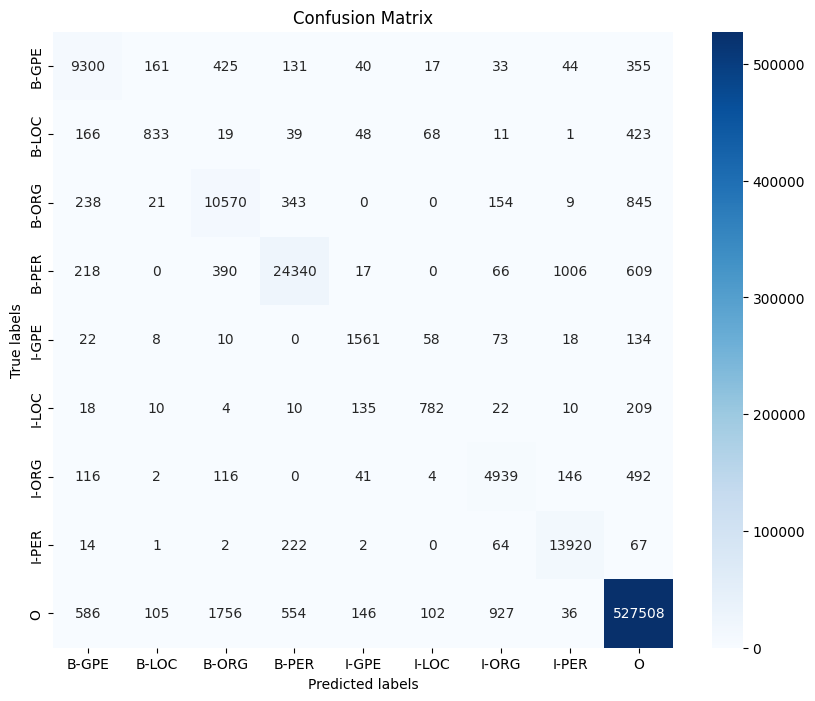

In [ ]:
conf_matrix = confusion_matrix(np.concatenate(stored_labels), np.concatenate(stored_predictions))
labels = sorted(list(set(np.concatenate(stored_labels))))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
id2label= {
    str(i):label for i, label in enumerate(label_list)
}

label2id = {
    label:str(i) for i, label in enumerate(label_list)
}

In [ ]:
import json

config = json.load(open('ner_model/config.json'))

In [ ]:
config['id2label'] = id2label
config['label2id'] = label2id

json.dump(config, open('ner_model/config.json', 'w'))

model_fine_tuned = AutoModelForTokenClassification.from_pretrained("ner_model")

test on evaluation text

In [ ]:
from transformers import pipeline

In [ ]:
nlp = pipeline("ner", model=model_fine_tuned, tokenizer=tokenizer)

example = "Ieri ho trovato un fiore in Trentino e l'ho portato all'ONU ma a loro non è piaciuto quindi Pedrotti mi ha sgridato"

ner_results = nlp(example)

print(ner_results)

[{'entity': 'B-GPE', 'score': 0.99392563, 'index': 7, 'word': '▁Trentino', 'start': 27, 'end': 36}, {'entity': 'B-ORG', 'score': 0.9823934, 'index': 15, 'word': 'ONU', 'start': 56, 'end': 59}, {'entity': 'B-PER', 'score': 0.9975248, 'index': 23, 'word': '▁Pedro', 'start': 91, 'end': 97}, {'entity': 'B-PER', 'score': 0.9975235, 'index': 24, 'word': 'tti', 'start': 97, 'end': 100}]
